In [1]:
#####
# test notebook to make sure simulation functions work
#####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from simulation_functions import (
    simulate_streams_and_liquidations, 
    calculate_pl, 
    simulate_and_calculate_pl, 
    calculate_liquidator_pl_with_prediction
)

from simulation_parameters import sample_params
from graphing_utils import graph_pl

In [2]:
from line_profiler import LineProfiler
lp = LineProfiler()

In [3]:
def clean_imported_df(df):
    df = df.drop(columns=['Unnamed: 0'])
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = pd.to_datetime(df['date'])
    return df

In [4]:
df = clean_imported_df(pd.read_csv('gas_prices_since_march_2020.csv'))

In [5]:
params = {'upfront_fee': 0,  # eth
 'monthly_opened_streams': 500,
 'average_stream_lifetime': 10,  # days
 'percent_accidently_liquidated_per_month': 20,
 'average_stream_size': 4000,  # usd
 'liquidator_capital': 20000,
 'upfront_hours': 4,
 'refund_rate': .5,  # fraction
 'gas_tank_size': 20,
 'max_days_to_return': 7,
 'max_liquidation_wait_time': 24,
 'min_self_liquidation_savings': 10,
 'gas_prediction_ability': .25,  # in hours - minimum value of 3 minutes
 'lowest_stream_cost_ratio': 1}  # ie user won't open stream if monthly value greater than 1x cost

In [6]:
df

,time,min_gas_price,lower_quartile_gas_price,median_gas_price,day,date,avg_median,price,three_min_median
0,2021-03-01 00:01:00,117.000000,119.571429,120.000000,0,2021-03-01,86.225093,1417.055653,102.000000
1,2021-03-01 00:02:00,1.000000,101.000000,102.000000,0,2021-03-01,87.958426,1416.776179,102.000000
2,2021-03-01 00:03:00,1.000000,92.000000,100.800000,0,2021-03-01,89.625093,1416.496704,100.800000
3,2021-03-01 00:04:00,93.750000,99.000000,104.880000,0,2021-03-01,90.745093,1416.217229,101.000000
4,2021-03-01 00:05:00,0.000012,95.000000,100.800000,0,2021-03-01,92.603759,1415.937755,100.800000
...,...,...,...,...,...,...,...,...,...
269713,2021-09-05 23:57:00,85.794043,90.400000,95.589399,6,2021-09-05,95.188837,3946.936866,94.868854
269714,2021-09-05 23:58:00,79.081657,85.446042,89.457596,6,2021-09-05,95.650061,3947.009910,94.000000
269715,2021-09-05 23:59:00,84.176648,92.036024,94.868854,6,2021-09-05,95.708499,3947.082953,94.868854
269716,2021-09-06 00:00:00,73.991949,80.000000,94.000000,0,2021-09-06,96.695696,3947.155996,102.000000


In [7]:
df = simulate_streams_and_liquidations(df, params)

In [8]:
df = calculate_pl(df, params)

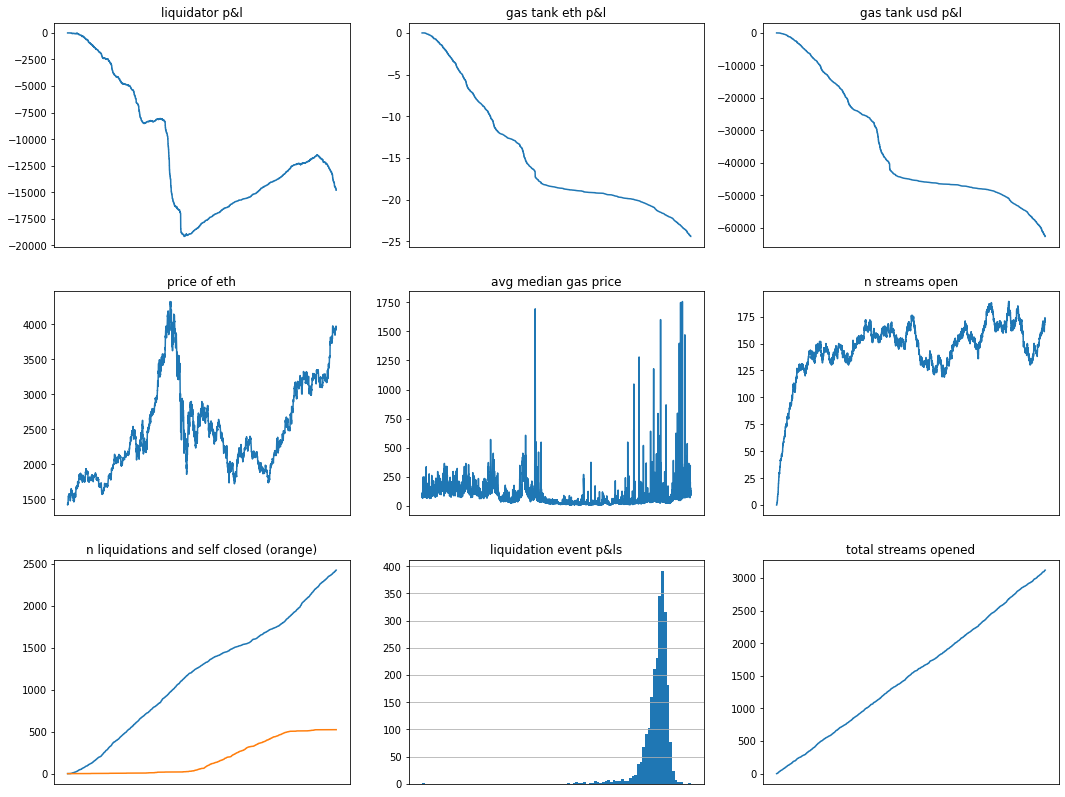

In [9]:
graph_pl(df)

In [10]:
incurred_cost_per_tx = np.sum(df['gas_tank_eth_pl']) / (np.sum(df['n_self_closed']) + 
                                                        np.sum(df['n_liquidated'])) / params['refund_rate']
print(incurred_cost_per_tx)

-0.01655108102415783


In [11]:
lp_wrapper = lp(simulate_streams_and_liquidations)
lp_wrapper(df, params)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.009846 s
File: /Users/mcurcio/Desktop/superfluid-liquidations/simulation_functions.py
Function: simulate_streams_and_liquidations at line 176

Line #      Hits         Time  Per Hit   % Time  Line Contents
   176                                           def simulate_streams_and_liquidations(df, params):
   177                                               """ simulates streams and liquidations data """
   178         1         21.0     21.0      0.2      n_minutes = df.shape[0]
   179         2       2936.0   1468.0     29.8      new_stream_times, liquidation_times, self_closed_times, liquidation_sizes, self_closed_sizes = simulate_streams(df,
   180         1          0.0      0.0      0.0                                                                                                                      params)
   181                                           
   182         1       1182.0   1182.0     12.0      df['n_opened'] = bin_times_and_sizes

In [12]:
lp_wrapper = lp(calculate_pl)
lp_wrapper(df, params)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.009846 s
File: /Users/mcurcio/Desktop/superfluid-liquidations/simulation_functions.py
Function: simulate_streams_and_liquidations at line 176

Line #      Hits         Time  Per Hit   % Time  Line Contents
   176                                           def simulate_streams_and_liquidations(df, params):
   177                                               """ simulates streams and liquidations data """
   178         1         21.0     21.0      0.2      n_minutes = df.shape[0]
   179         2       2936.0   1468.0     29.8      new_stream_times, liquidation_times, self_closed_times, liquidation_sizes, self_closed_sizes = simulate_streams(df,
   180         1          0.0      0.0      0.0                                                                                                                      params)
   181                                           
   182         1       1182.0   1182.0     12.0      df['n_opened'] = bin_times_and_sizes

In [12]:
# show effect of prediciton on gas price paid
refund_rate_to_costs = []
for refund_rate in [.1, .3, .5, .7, .9]:
    params['refund_rate'] = refund_rate
    incurred_cost_per_tx = []
    for pred in np.linspace(0,4, 17):
        params['gas_prediction_ability'] = pred
        df = calculate_pl(df, params)
        incurred_cost_per_tx.append(np.sum(df['gas_tank_eth_pl']) / (np.sum(df['n_self_closed']) + np.sum(df['n_liquidated'])))
    refund_rate_to_costs.append(incurred_cost_per_tx)

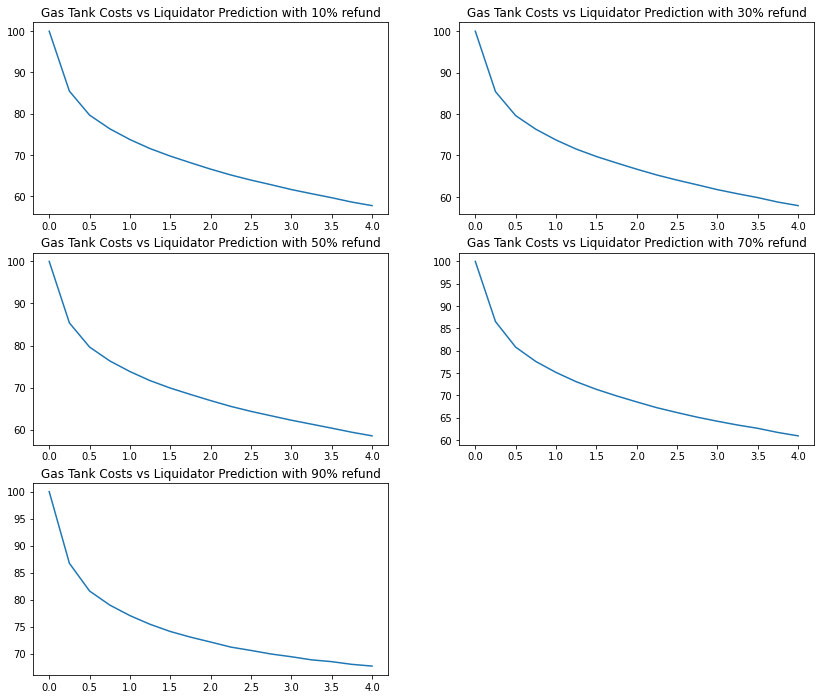

In [13]:
# for each refund rate, show the effect of prediction ability on the slope - want incentives to be aligned
fig, axs = plt.subplots(3,2,figsize=(14,12))
titles = ["Gas Tank Costs vs Liquidator Prediction with {}% refund".format(int(x*100)) for x in [.1, .3, .5, .7, .9]]
for i, ax in enumerate(axs.flat):
    if i == 5:
        ax.axis('off')
        continue
    sns.lineplot(x = np.linspace(0,4, 17), y = refund_rate_to_costs[i] / min(refund_rate_to_costs[i]) * 100, ax=ax) # care about percent reduction
    ax.set_title(titles[i])
    

In [18]:
# randomly sample
params = sample_params()
params

{'upfront_fee': 0.043273100131568154,
 'monthly_opened_streams': 242.4895050403164,
 'average_stream_lifetime': 138.90438649142155,
 'percent_accidently_liquidated_per_month': 9.271192891400789,
 'average_stream_size': 2696.515844518127,
 'liquidator_capital': 64772.50581552407,
 'upfront_hours': 10.001949352797817,
 'refund_rate': 0.542845769406709,
 'gas_tank_size': 204.80371559413655,
 'max_days_to_return': 70.40898737755161,
 'max_liquidation_wait_time': 45.95180001704594,
 'min_self_liquidation_savings': 19.095816426331574,
 'gas_prediction_ability': 0.6404874188777552,
 'lowest_stream_cost_ratio': 1.0466110640157669}

In [48]:
df = simulate_and_calculate_pl(df, params)

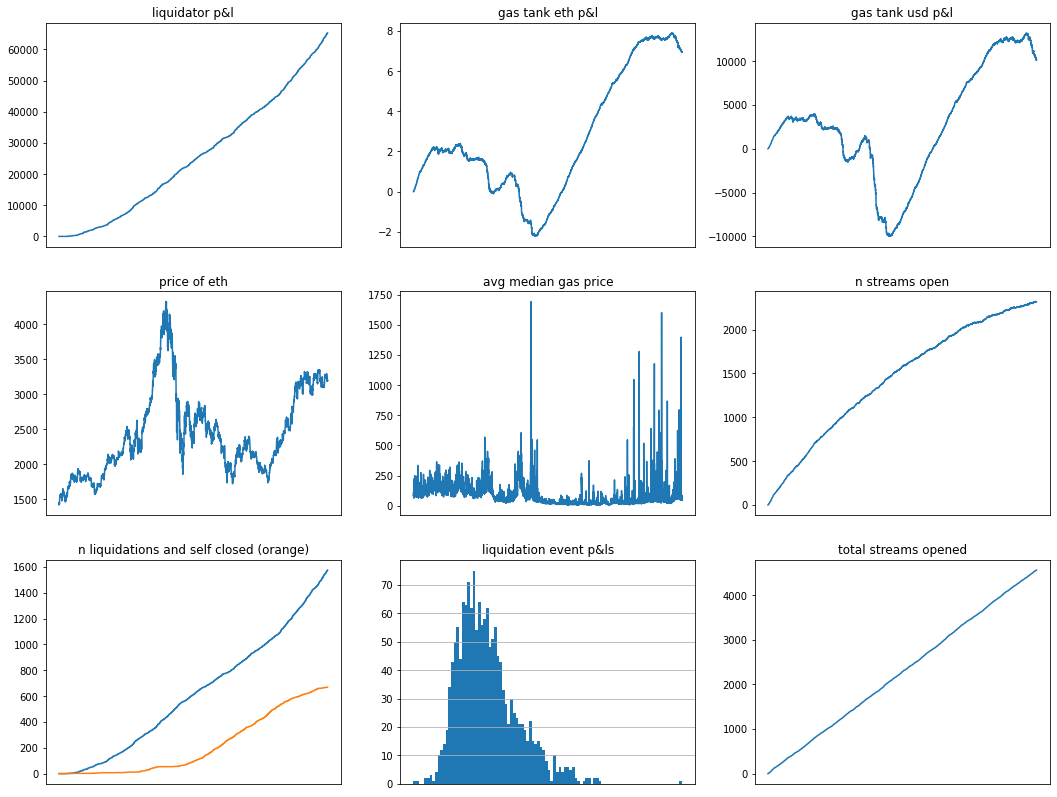

In [49]:
graph_pl(df)